In [11]:
import numpy as np
from itertools import combinations, groupby
from collections import Counter

# Sample data
orders = np.array([[1,'apple'], [1,'egg'], [1,'milk'], [2,'carrot'], [2,'milk'], [3,'apple'], [3,'egg'], [3,'carrot'], [4,'apple'], [4,'egg'], [5,'apple'], [5,'carrot']], dtype=object)

# Generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    
    # For each order, generate a list of items in that order
    for order_id, order_object in groupby(orders, lambda x: x[0]):
        item_list = [item[1] for item in order_object]      
    
        # For each item list, generate item pairs, one at a time
        for item_pair in combinations(item_list, 2):
            yield item_pair                                      


# Counter iterates through the item pairs returned by our generator and keeps a tally of their occurrence
Counter(get_item_pairs(orders))

Counter({('apple', 'egg'): 3,
         ('apple', 'milk'): 1,
         ('egg', 'milk'): 1,
         ('carrot', 'milk'): 1,
         ('apple', 'carrot'): 2,
         ('egg', 'carrot'): 1})

In [148]:
import pandas as pd
import numpy as np
import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display

In [149]:
# Function that returns the size of an object in MB
def size(obj):
    return "{0:.2f} MB".format(sys.getsizeof(obj) / (1000 * 1000))

In [150]:
orders = pd.read_csv('instacart_transaction.csv')
print('orders -- dimensions: {0};   size: {1}'.format(orders.shape, size(orders)))
display(orders.head())
print("Mean: ", orders["add_to_cart_order"].mean())

orders -- dimensions: (32434489, 4);   size: 1037.90 MB


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Mean:  8.351075517175559


In [151]:
# Convert from DataFrame to a Series, with order_id as index and item_id as value
orders = orders.set_index('order_id')['product_id'].rename('item_id')
display(orders.head(10))
type(orders)

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
2    17794
2    40141
2     1819
2    43668
3    33754
Name: item_id, dtype: int64

pandas.core.series.Series

In [152]:
print('dimensions: {0};   size: {1};   unique_orders: {2};   unique_items: {3}'
      .format(orders.shape, size(orders), len(orders.index.unique()), len(orders.value_counts())))

dimensions: (32434489,);   size: 518.95 MB;   unique_orders: 3214874;   unique_items: 49677


In [153]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().to_numpy()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns] 

In [154]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

In [155]:
%%time
rules = association_rules(orders, 0.08)  

Starting order_item:               32434489
Items with support >= 0.08:            2228
Remaining order_item:              22033814
Remaining orders with 2+ items:     2786012
Remaining order_item:              21736558
Item pairs:                         4076065
Item pairs with support >= 0.08:       2234

Wall time: 1min 30s


In [156]:
# Replace item ID with item name and display association rules
item_name   = pd.read_csv('products.csv')
item_name   = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)
display(rules_final)

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Acai & Mixed Berries Yogurt,2478,0.088944,19213,0.689624,8625,0.309582,0.128975,0.287304,0.416610
1,Icelandic Style Skyr Blueberry Non-fat Yogurt,Nonfat Icelandic Style Strawberry Yogurt,2699,0.096877,19213,0.689624,10636,0.381764,0.140478,0.253761,0.367970
2,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Raspberry Yogurt,3802,0.136467,19213,0.689624,16340,0.586501,0.197887,0.232681,0.337402
8,Non Fat Raspberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,3422,0.122828,16340,0.586501,19213,0.689624,0.209425,0.178109,0.303680
11,Soda,Zero Calorie Cola,2417,0.086755,31090,1.115932,7685,0.275842,0.077742,0.314509,0.281835
...,...,...,...,...,...,...,...,...,...,...,...
131,Organic Yellow Onion,Banana,4994,0.179253,112943,4.053931,466348,16.738909,0.044217,0.010709,0.002642
140,Organic Cucumber,Banana,3472,0.124623,80114,2.875580,466348,16.738909,0.043338,0.007445,0.002589
119,Raspberries,Banana,2365,0.084888,56187,2.016754,466348,16.738909,0.042092,0.005071,0.002515
519,Cucumber Kirby,Bag of Organic Bananas,3103,0.111378,96811,3.474895,373483,13.405649,0.032052,0.008308,0.002391


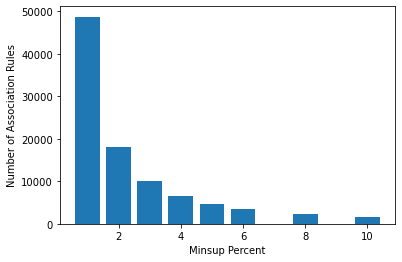

In [111]:
import matplotlib.pyplot as plt

x = [1,2,3,4,5,6,8,10]
y = [48751,18153,10049,6569,4666,3504,2234,1560 ]

plt.xlabel("Minsup Percent")
plt.ylabel("Number of Association Rules")

plt.bar(x,y)
plt.show()